Python script that plots maps of the global annual mean precipitation in IMERG observations and CMIP6 models and draws rectangles over regions of interest with significant ITCZs. 

In [1]:
#Author: Alex Gonzalez
#Date: November 2025
#Paper: JGR-Atmospheres

Figure 1: Annual mean precipitation biases in CMIP6 models over the global tropics: a) IMERG
combined microwave and IR precipitation observations (1998–2024), b) CMIP6 model median precipitation
(1980–2014), and c) CMIP6 model median precipitation bias (Panel b minus panel a).
The gray contour lines in panels a and b represent 5 mm day−1 and the rectangles represent the
four regions (East Pacific Ocean, Atlantic, Indian Ocean, and Central Pacific Ocean) that we apply
our daily ITCZ states algorithm to, with a main focus on the east Pacific Ocean in this study.

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
figfolder = '/home/alex.gonzalez/CMIP6_ITCZ_state_project/figures/methods_paper/revision/'
figname = 'Annual_CMIP6_precip_bias_map.pdf'

In [3]:
# Observations and CMIP6 model names
dataset = ['IMERG','BCC-CSM2-MR',
            'CAMS-CSM1-0',
            'CESM2',
            'CESM2-WACCM',
            'CMCC-CM2-HR4',
            'CMCC-CM2-SR5',
            'CMCC-ESM2',
            'CNRM-CM6-1-HR',
            'E3SM-1-0',
            'E3SM-2-0',
            'E3SM-2-0-NARRM',
            'EC-Earth3',
            'EC-Earth3-AerChem',
            'EC-Earth3-CC',
            'EC-Earth3-Veg',
            'EC-Earth3-Veg-LR',
            'FGOALS-f3-L',
            'GFDL-CM4',
            'GFDL-ESM4',
            'HadGEM3-GC31-MM',
            'MPI-ESM1-2-HR',
            'MRI-ESM2-0',
            'NorESM2-MM',
            'SAM0-UNICON',
            'TaiESM1']

In [4]:
# datasets as an xarray
datasets_xr = xr.DataArray(dataset, coords=[dataset], dims=['dataset'])
ndataset = len(dataset)

In [28]:
# latitude and longitudes of interest for plots (longitudes from -180 to 180 only for now)
lat0 = -30
lat1 = 30
lon0 = -180
lon1 = 180

# central longitude for plots
clon = -145

# seconds per day conversion
spd = 86400

# common lat, lon, and time names
lat_name = 'lat'
lon_name = 'lon'
tim_name = 'time'

In [7]:
# Observations precipitation directory and filename – this is only to save latitude and longitude array
dri = '/srv/lss/IMERG_1deg/total_precip/'
fni = 'imerg_1deg_1998-2024_daily_180.nc'
data = xr.open_dataset(dri+fni, engine='netcdf4')

# save latitudes and longitudes for all datasets here
lat_all = data[lat_name].sel({lat_name:slice(lat0,lat1)})
lon_all = data[lon_name].sel({lon_name:slice(lon0,lon1)})
nlat = len(lat_all)
nlon = len(lon_all)

In [17]:
# initialize large precipitation array (latitude,longitude,dataset)
pr_mean = np.zeros((nlat,nlon,ndataset))

In [18]:
# loop through datasets and put precipitation data
for jj in range(0,ndataset,1):
    if dataset[jj] == 'IMERG':
        dri = '/srv/lss/IMERG_1deg/total_precip/'
        fni = 'imerg_1deg_1998-2024_daily_180.nc'
        unit_const = 1
        nc_name = 'precipitation'
    else:
        dri = '/srv/lss/CMIP6_precip_1deg/'+dataset[jj]+'/'
        fni = 'pr_'+dataset[jj]+'_1980-2014_1deg_180.nc'
        unit_const = spd 
        nc_name = 'pr'
    
    data = xr.open_dataset(dri+fni, engine='netcdf4')
    time_all = data['time']

    pr_mean[:,:,jj] = unit_const*data[nc_name].sel({lat_name:slice(lat0,lat1),lon_name:slice(lon0,lon1)}).mean(dim=(tim_name))

In [20]:
# save precipitation as an xarray
pr_mean_xr = xr.DataArray(pr_mean,coords=[lat_all,lon_all,dataset],dims=[lat_name,lon_name,'dataset'])

In [21]:
# compute precipitation bias
pr_bias = pr_mean_xr[:,:,1:]- pr_mean_xr.sel(dataset='IMERG')

In [22]:
# compute model median precipitation
pr_median = pr_mean_xr[:,:,1:].median(dim=('dataset'))

# compute model median precipitation bias
pr_bias_median = pr_bias.median(dim=('dataset'))

In [23]:
# function that draws a latitue by longitude rectangle for each region of interest
def rect_box_array(lat0,lat1,lon0,lon1):
    lat_plt = np.array([lat0,lat1,lat1,lat0,lat0])
    lon_plt = np.array([lon0,lon0,lon1,lon1,lon0])
    return lon_plt, lat_plt

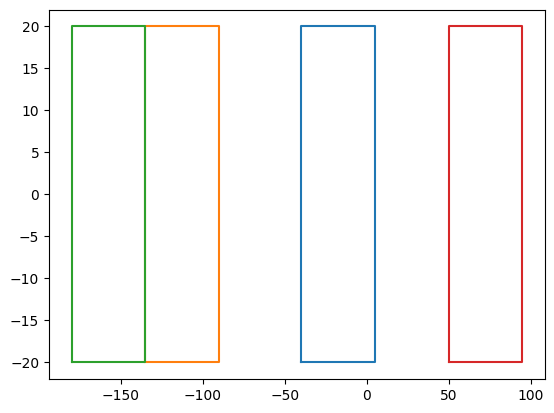

In [24]:
# latitudes of boxes
lat0_box = -20
lat1_box = 20

# longitudes of boxes
# Atl box
lon0_atla = -40
lon1_atla = 5

# EPac box
lon0_epac = -135
lon1_epac = -90

# CPac box
lon0_cpac = -180
lon1_cpac = -135

# Indi box
lon0_indi = 50
lon1_indi = 95

# run rectangle function for each region
[lon_plt_atla,lat_plt_atla] = rect_box_array(lat0_box,lat1_box,lon0_atla,lon1_atla) 
[lon_plt_epac,lat_plt_epac] = rect_box_array(lat0_box,lat1_box,lon0_epac,lon1_epac) 
[lon_plt_cpac,lat_plt_cpac] = rect_box_array(lat0_box,lat1_box,lon0_cpac,lon1_cpac) 
[lon_plt_indi,lat_plt_indi] = rect_box_array(lat0_box,lat1_box,lon0_indi,lon1_indi) 

# test rectangles
plt.plot(lon_plt_atla,lat_plt_atla)
plt.plot(lon_plt_epac,lat_plt_epac)
plt.plot(lon_plt_cpac,lat_plt_cpac)
plt.plot(lon_plt_indi,lat_plt_indi)

In [25]:
levp = np.arange(2., 16., 2.)
color_map = plt.colormaps.get_cmap('Blues')
levp_anom = np.arange(-5., 6., 1.)
levpl = [5]
color_map_rb = plt.colormaps.get_cmap('RdBu')

In [32]:
# 
import shapely
import matplotlib.ticker as mticker
import shapely.geometry as sgeom

box = sgeom.box(minx=-180, maxx=180, miny=lat0, maxy=lat1)
x0, y0, x1, y1 = box.bounds

proj = ccrs.PlateCarree(central_longitude=clon)
box_proj = ccrs.PlateCarree(central_longitude=0)

In [33]:
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)

In [34]:
# this will only work for longitudes from -180 to 180 (not 0 to 360)
lon_plt_atla_plt = lon_plt_atla - clon
lon_plt_epac_plt = lon_plt_epac - clon
lon_plt_cpac_plt = lon_plt_cpac - clon
lon_plt_indi_plt = lon_plt_indi - 360 - clon
lon_plt_indi_plt

array([-165, -165, -120, -120, -165])

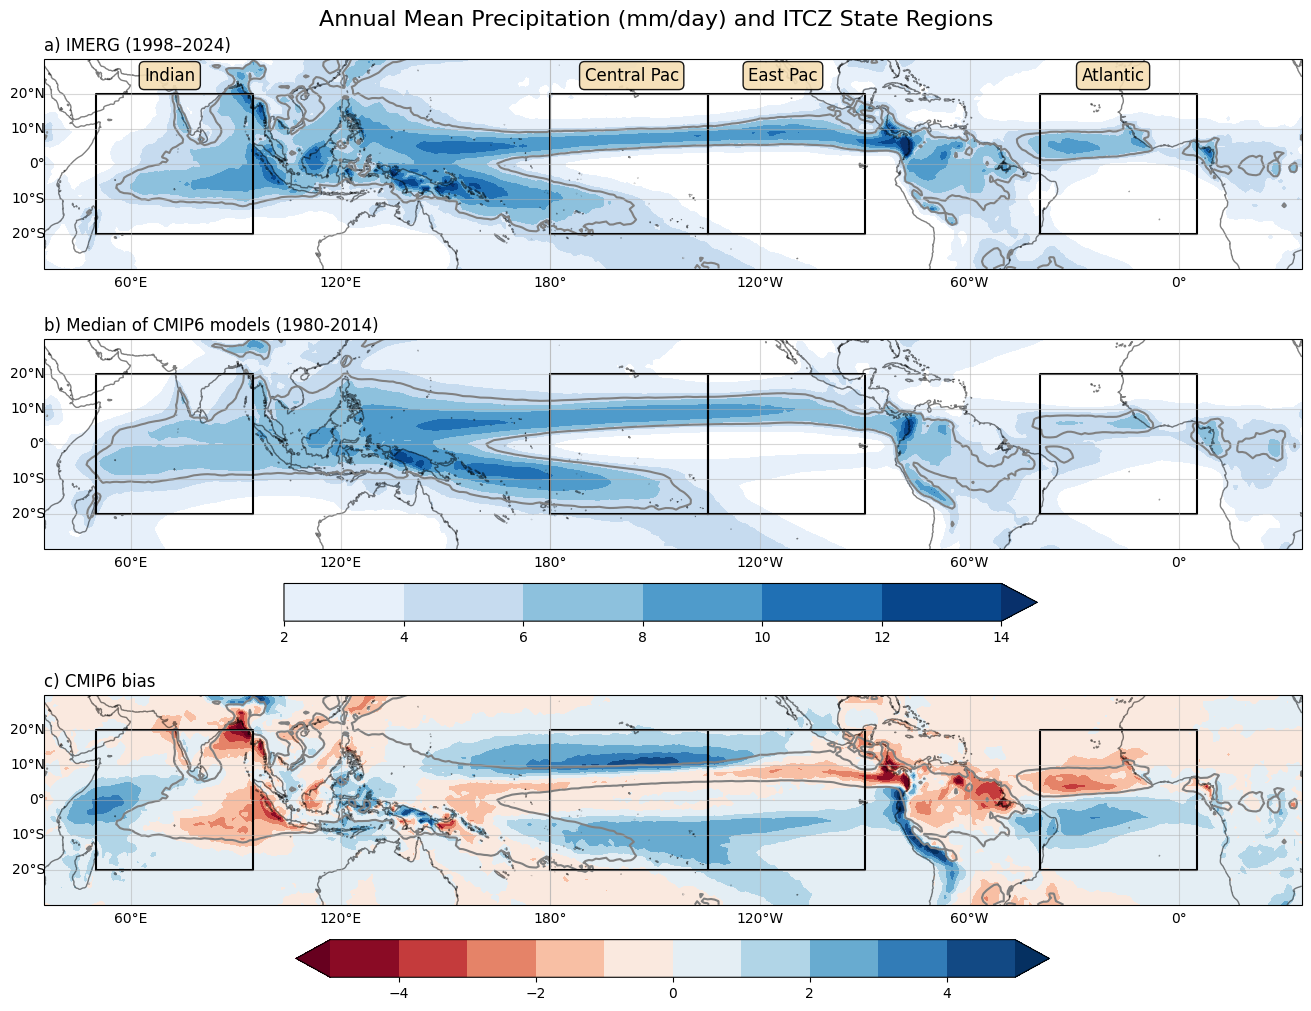

In [35]:
# plot maps of precipitation
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

npan = 3 # one per phase
# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(13,10), constrained_layout=True)
fig.suptitle(r'Annual Mean Precipitation (mm/day) and ITCZ State Regions', fontsize=16)
for j in range(0,npan,1):
    ax1 = fig.add_subplot(npan,1,j+1,projection=proj)
    ax1.coastlines('50m',alpha=0.5)
    gl = ax1.gridlines(draw_labels=True, alpha=0.5, crs=ccrs.PlateCarree())
    #gl.xlocator = mticker.FixedLocator([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, -160, -140, -120, -100, -80,-60,-40,-20])
    ax1.set_extent([x0, x1, y0, y1], box_proj)
    gl.top_labels = False
    gl.right_labels = False
    
    if j == 0:
        plt.title(r'a) IMERG (1998–2024)',loc='left')
        cf = plt.contourf(lon_all,lat_all,pr_mean_xr.sel(dataset='IMERG'), cmap=color_map, transform=ccrs.PlateCarree(),
             levels=levp, extend ='max')
        cl = plt.contour(lon_all,lat_all,pr_mean_xr.sel(dataset='IMERG'), colors='grey', transform=ccrs.PlateCarree(),
             levels=levpl)

        # titles for each rectangle
        ax1.text(0.43, 0.963, 'Central Pac', transform=ax1.transAxes, fontsize=12,
                 verticalalignment='top', multialignment='center', bbox=props)
        ax1.text(0.56, 0.963, 'East Pac', transform=ax1.transAxes, fontsize=12,
                 verticalalignment='top', multialignment='center', bbox=props)
        ax1.text(0.825, 0.963, 'Atlantic', transform=ax1.transAxes, fontsize=12,
                 verticalalignment='top', multialignment='center', bbox=props)
        ax1.text(0.08, 0.963, 'Indian', transform=ax1.transAxes, fontsize=12,
                verticalalignment='top', multialignment='center', bbox=props)

    if j == 1:
        plt.title(r'b) Median of CMIP6 models (1980-2014)',loc='left')
        cf = plt.contourf(lon_all,lat_all, pr_median, cmap=color_map, transform=ccrs.PlateCarree(),
             levels=levp, extend ='max')
        cl = plt.contour(lon_all,lat_all,pr_median, colors='grey', transform=ccrs.PlateCarree(),
             levels=levpl)
        cb = plt.colorbar(cf, orientation='horizontal')
    if j == 2:
        plt.title(r'c) CMIP6 bias',loc='left')
        cf = plt.contourf(lon_all,lat_all,pr_bias_median, cmap=color_map_rb, transform=ccrs.PlateCarree(),
             levels=levp_anom, extend ='both')
        #cl = plt.contour(lon_all,lat_all,pr_mean_xr.sel(dataset='IMERG'), colors='grey', transform=ccrs.PlateCarree(),
             #levels=levpl)
        cb = plt.colorbar(cf, orientation='horizontal')

    # draw rectangles
    plt.plot(lon_plt_atla_plt,lat_plt_atla,color='k')
    plt.plot(lon_plt_epac_plt,lat_plt_epac,color='k')
    plt.plot(lon_plt_cpac_plt,lat_plt_cpac,color='k')
    plt.plot(lon_plt_indi_plt,lat_plt_indi,color='k')

plt.savefig(figfolder+figname,bbox_inches="tight",transparent=False,dpi=150)